##Librerias

In [3]:
!pip install tensorflow
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
# tf.python.control_flow_ops = tf #esta línea evita un conflicto entre Keras y Tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from scikeras.wrappers import KerasClassifier


import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import   OneHotEncoder, StandardScaler



In [6]:
from tensorflow.python.client import device_lib

def gpuon():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos if x.device_type == 'GPU'])

gpuon()

['/device:GPU:0']


In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan  9 07:42:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |    312MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Carga de datos

In [7]:
df_sin_movilidad_20_21 = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_sin_movilidad_20_21.csv", sep = ";")

In [8]:
df_sin_movilidad_20_21.index = df_sin_movilidad_20_21.fecha  ##Set_index('fecha')
df_sin_movilidad_20_21 = df_sin_movilidad_20_21.drop('fecha', axis=1)
df_sin_movilidad_20_21

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,alto_riesgo,peligro,vulner,ocurrencia,municipio,cod_municipio,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0002I,0.0,12.4,12.1,11.9,0.3,8.3,457.0,1020.7,1020.1,...,Sí,Molt Alt,Molt Alta,0,Vandellos l’Hospitalet de l’Infant,43162,3,1,0,1
2015-01-01,WE,0.0,11.3,11.1,10.7,5.3,7.8,449.0,1027.2,1021.7,...,Sí,Alt,Molt Alta,0,Vilanova del Vallès,8946,3,1,0,1
2015-01-01,WG,0.0,8.5,8.1,7.6,0.8,2.3,428.0,1020.0,1019.6,...,Sí,Molt Alt,Moderada,0,Algerri,25528,3,1,0,1
2015-01-01,WI,0.0,7.8,7.6,7.4,2.1,4.1,468.0,1031.5,1031.3,...,Sí,Molt Alt,Baixa,0,Maials,25761,3,1,0,1
2015-01-01,WJ,0.0,12.3,11.7,11.3,1.0,2.4,449.0,1000.2,999.7,...,Sí,Molt Alt,Moderada,0,El Masroig,43675,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,UN,0.0,14.8,14.3,14.0,1.4,3.5,526.0,954.0,953.8,...,Sí,Alt,Alta,0,Cassà de la Selva,17462,1,32,0,2
2022-02-01,UO,0.0,14.0,13.7,13.3,5.5,10.2,574.0,1023.8,1023.4,...,Sí,Exclos,Moderada,0,Fornells de la Selva,17466,1,32,0,2
2022-02-01,UP,0.0,13.6,13.3,13.1,2.2,4.3,544.0,1013.9,1013.6,...,Sí,Exclos,Molt Alta,0,Cabrils,8489,1,32,0,2


In [9]:
df_sin_movilidad_20_21 = df_sin_movilidad_20_21.loc['2020-02-21':'2021-05-09'] 

##1. Division de datos (UnderSampling Manual)
---



In [10]:
df_sin_movilidad_20_21.groupby("ocurrencia").count()

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,municipio,cod_municipio,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,,,
0,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,...,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133
1,382,382,382,382,382,382,382,382,382,382,...,382,382,382,382,382,382,382,382,382,382


In [11]:
df_sin_movilidad_20_21.groupby("ocurrencia").count().columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'municipio', 'cod_municipio', 'laborable', 'dayofyear', 'weekend',
       'mes'],
      dtype='object')

In [12]:
df_ocurrencia_0 = df_sin_movilidad_20_21[df_sin_movilidad_20_21["ocurrencia"]==0].sample(382)

In [13]:
df_ocurrencia_1 = df_sin_movilidad_20_21[df_sin_movilidad_20_21["ocurrencia"]==1]

In [14]:
df_sin_movilidad_20_21 =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_sin_movilidad_20_21.shape

(764, 23)

In [15]:
x = df_sin_movilidad_20_21['indicativo'].unique()
len(x)

186

In [16]:
X = df_sin_movilidad_20_21.drop( ['ocurrencia', 'municipio', 'cod_municipio', 'indicativo'], axis=1)
y = df_sin_movilidad_20_21['ocurrencia']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,altitud,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,
2020-06-24,0.0,33.1,32.4,31.8,3.4,6.0,985.0,1013.1,1013.0,35.0,790.0,1.60,Sí,Moderat,Molt Alta,2,176,0,6
2021-03-26,0.0,20.4,19.4,18.5,2.7,5.8,831.0,1017.6,1017.4,37.0,790.0,1.60,Sí,Moderat,Molt Alta,4,85,0,3
2020-07-30,0.0,36.0,35.5,35.1,2.3,4.9,901.0,997.2,997.0,29.0,281.0,3.22,Sí,Molt Alt,Molt Alta,3,212,0,7
2020-09-08,0.0,26.8,25.6,25.3,1.5,4.2,504.0,1022.2,1022.0,40.0,676.0,9.00,Sí,Molt Alt,Molt Alta,1,252,0,9
2021-02-01,0.0,17.7,17.4,17.1,12.4,22.0,579.0,1005.7,1004.8,38.0,263.0,2.30,Sí,Molt Alt,Moderada,0,32,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,0.0,17.4,16.8,15.9,6.4,10.9,858.0,914.2,914.0,47.0,732.0,0.90,Sí,Moderat,Molt Alta,3,121,0,4
2020-02-26,0.0,12.9,12.6,12.3,4.8,9.9,724.0,1017.5,1017.0,40.0,881.0,3.22,Sí,Moderat,Moderada,2,57,0,2
2021-02-20,0.0,17.1,16.8,16.5,3.3,5.2,663.0,1017.1,1016.6,43.0,556.0,4.10,Sí,Exclos,Moderada,5,51,1,2


## 1.2. Normalizacion datos



In [18]:
# normalizacion de los datos numericos
numericalCols_train = X_train[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total" ]]  
numericalCols_test = X_test[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total" ]]  

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((611, 12), (153, 12))

In [19]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()

# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((611, 12), (153, 12))

In [20]:
Other_var_train = X_train[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test = X_test[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [21]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)

In [22]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((611, 28), (611,), (153, 28), (153,))

In [23]:
X_train = df_train_scaled.reshape(df_train_scaled.shape[0],df_train_scaled.shape[1],1)
X_train.shape, y_train.shape

((611, 28, 1), (611,))

In [24]:
X_test = df_test_scaled.reshape(df_test_scaled.shape[0],df_test_scaled.shape[1],1)
X_test.shape, y_test.shape

((153, 28, 1), (153,))

## 1.3. Model LSTM (df_all_sin_mov -  UnderSampling Manual)

Vamos a generar una LSTM con dos capas

1. LSTM - Es la capa que trabaja en la clasificación. Donde se indica el numero de neuronas
2. Capa de dropout (apagado de neuronas)
3. Capa de activacion sigmoide ya que estamos ante una clasificación biaria (0-1)
4. Una única neurona de salida con un sigmoide

In [34]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer

def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((28,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(28, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [26]:
model = modelLSTM()

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 28)                5628      
                                                                 
 dropout_1 (Dropout)         (None, 28)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 29        
                                                                 
Total params: 167,257
Trainable params: 167,257
Non-trainable params: 0
_________________________________________________________________


In [162]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.4828

20/20 [==============================] - 12s 531ms/step - loss: 0.7053 - accuracy: 0.4828 - val_loss: 0.6929 - val_accuracy: 0.4902
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.4959

20/20 [==============================] - 7s 365ms/step - loss: 0.7051 - accuracy: 0.4959 - val_loss: 0.6920 - val_accuracy: 0.5098
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.5172

20/20 [==============================] - 11s 595ms/step - loss: 0.6984 - accuracy: 0.5172 - val_loss: 0.6838 - val_accuracy: 0.5752
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.5941

20/20 [==============================] - 8s 432ms/step - loss: 0.6745 - accuracy: 0.5941 - val_loss: 0.6378 - val_accuracy: 0.6536
Epoch 5/20
20/20 [==============================] - 2s 92ms/step - loss: 0.6795 - accuracy: 0.6023 - val_loss: 0.6660 - val_accuracy: 0.6275
Epoch 6/20
20/20 [==============================] - 2s 102ms/step - loss: 0.6780 - accuracy: 0.5761 - val_loss: 0.6730 - val_accuracy: 0.5948
Epoch 7/20
20/20 [==============================] - 2s 92ms/step - loss: 0.6835 - accuracy: 0.5974 - val_loss: 0.6708 - val_accuracy: 0.5948
Epoch 8/20
20/20 [==============================] - 1s 56ms/step - loss: 0.6760 - accuracy: 0.5892 - val_loss: 0.6738 - val_accuracy: 0.5882
Epoch 9/20
20/20 [==============================] - 2s 82ms/step - loss: 0.6822 - accuracy: 0.5827 - val_loss: 0.6780 - val_accuracy: 0.5752
Epoch 10/20
20/20 [==============================] - 2s 86ms/step - loss: 0.6759 - accuracy: 0.5957 - val_loss: 0.6762 - val_accuracy: 0.5752
Epoch 11/20
20/20 [==

In [163]:
scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

5/5 - 0s - loss: 0.6920 - accuracy: 0.4314 - 132ms/epoch - 26ms/step
accuracy: 43.14%


In [164]:
y_pred_model_1 = model.predict(X_test)

5/5 [==============================] - 0s 12ms/step


In [165]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test, y_pred_model1))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66        75
           1       0.00      0.00      0.00        78

    accuracy                           0.49       153
   macro avg       0.25      0.50      0.33       153
weighted avg       0.24      0.49      0.32       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[75  0]
 [78  0]]


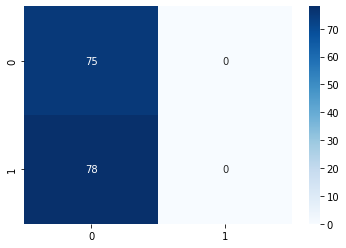

In [166]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

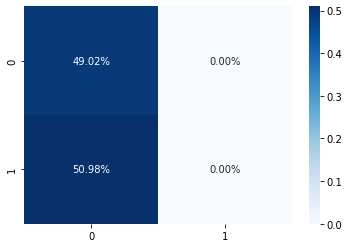

In [167]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

## 1.3.1 GridSearch -  Modelo LSTM con division manual (X_train y_train)

In [39]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.582647 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.572944 (0.052901) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.507370 (0.001653) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.507370 (0.001653) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.564521 (0.056252) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.507357 (0.003991) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.509010 (0.004024) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [40]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f55d649f280>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

In [41]:
# print classification report
y_pred = final_model.predict(X_test.astype(np.float32))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.48      0.56        81
           1       0.55      0.72      0.63        72

    accuracy                           0.59       153
   macro avg       0.61      0.60      0.59       153
weighted avg       0.61      0.59      0.59       153



In [42]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')


Conjunto de datos de validación
  Exactitud:     0.59477
  Precisión:     0.60710
  Exhaustividad: 0.60185


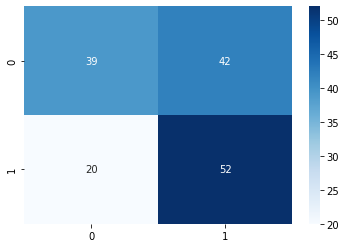

In [43]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

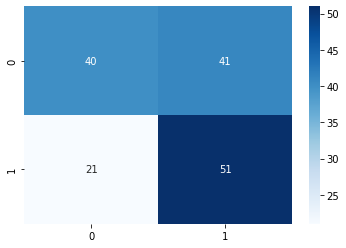

In [44]:
y_pred = (final_model.predict_proba(X_test)[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

## 1.4. Model LSTM clases balanceadas con SMOTE

In [46]:
from imblearn.over_sampling import SMOTE 
X_smote , y_smote = SMOTE().fit_resample( df_train_scaled, y_train)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote == 0)))

Before OverSampling, counts of label '1': 310
Before OverSampling, counts of label '0': 301 

After OverSampling, the shape of train_X: (620, 28)
After OverSampling, the shape of train_y: (620,) 

After OverSampling, counts of label '1': 310
After OverSampling, counts of label '0': 310


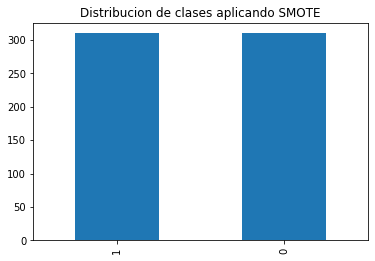

In [47]:
pd.Series(y_smote).value_counts().plot(kind='bar', title='Distribucion de clases aplicando SMOTE')

Este gráfico muestra claramente que ahora tenemos una gran cantidad de incendios que antes no teníamos. Esos son todos los puntos de datos sintéticos que se ha creado con SMOTE.



In [48]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_smote = X_smote.reshape(X_smote.shape[0],X_smote.shape[1],1)
X_smote.shape, y_smote.shape

((620, 28, 1), (620,))

In [49]:
X_smote_float=X_smote.astype(np.float32)

In [50]:
y_smote_int = y_smote.astype(np.int32)

In [51]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=5)

model_smote = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_smote.fit(X_smote_float, y_smote_int,validation_data=(X_test, y_test),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7154 - accuracy: 0.5197

20/20 [==============================] - 7s 283ms/step - loss: 0.7154 - accuracy: 0.5177 - val_loss: 0.6999 - val_accuracy: 0.4902
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7130 - accuracy: 0.4786

20/20 [==============================] - 5s 275ms/step - loss: 0.7127 - accuracy: 0.4790 - val_loss: 0.6917 - val_accuracy: 0.4902
Epoch 3/20
19/20 [===========================>..] - ETA: 0s - loss: 0.6958 - accuracy: 0.5543

20/20 [==============================] - 5s 255ms/step - loss: 0.6971 - accuracy: 0.5532 - val_loss: 0.6811 - val_accuracy: 0.5817
Epoch 4/20
19/20 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5576

20/20 [==============================] - 5s 276ms/step - loss: 0.6864 - accuracy: 0.5629 - val_loss: 0.6788 - val_accuracy: 0.5948
Epoch 5/20
20/20 [==============================] - 1s 45ms/step - loss: 0.6775 - accuracy: 0.5758 - val_loss: 0.6846 - val_accuracy: 0.5686
Epoch 6/20
20/20 [==============================] - 1s 46ms/step - loss: 0.6701 - accuracy: 0.5758 - val_loss: 0.6813 - val_accuracy: 0.5621
Epoch 7/20
20/20 [==============================] - 1s 47ms/step - loss: 0.6605 - accuracy: 0.6081 - val_loss: 0.6829 - val_accuracy: 0.5882
Epoch 8/20
20/20 [==============================] - 1s 46ms/step - loss: 0.6810 - accuracy: 0.5677 - val_loss: 0.6837 - val_accuracy: 0.6013
Epoch 9/20
20/20 [==============================] - 1s 47ms/step - loss: 0.6701 - accuracy: 0.5742 - val_loss: 0.6879 - val_accuracy: 0.5752
Epoch 9: early stopping


In [52]:
scores = model_smote.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_smote.metrics_names[1], scores[1] * 100))


5/5 - 0s - loss: 0.6879 - accuracy: 0.5752 - 76ms/epoch - 15ms/step
accuracy: 57.52%


In [53]:
# print classification report
y_pred_model_bal = model_smote.predict(X_test)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test, y_pred_model_bal_1))

5/5 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        81
           1       0.00      0.00      0.00        72

    accuracy                           0.53       153
   macro avg       0.26      0.50      0.35       153
weighted avg       0.28      0.53      0.37       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[81  0]
 [72  0]]


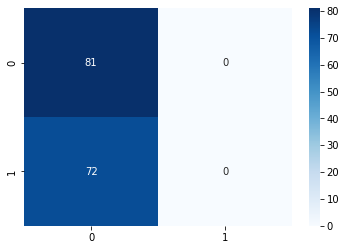

In [54]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

## 1.4.1 GridSearch - Modelo LSTM con division manual (X_smote_float, y_smote_int)

In [60]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_smote_float, y_smote_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.601613 using {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.569355 (0.030857) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.501613 (0.003226) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.501613 (0.003226) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.601613 (0.044053) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.501613 (0.003226) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000000) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [61]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f55d649f280>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

In [62]:
# print classification report
y_pred = final_model.predict(X_test.astype(np.float32))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.35      0.47        81
           1       0.54      0.86      0.66        72

    accuracy                           0.59       153
   macro avg       0.64      0.60      0.57       153
weighted avg       0.64      0.59      0.56       153



In [63]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')


Conjunto de datos de validación
  Exactitud:     0.58824
  Precisión:     0.63799
  Exhaustividad: 0.60340


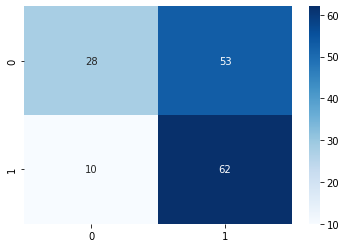

In [64]:
y_pred = final_model.predict(X_test.astype('float32'))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

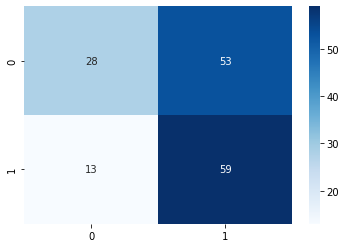

In [65]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

## 1.5. Model LSTM clases balanceadas con RandomUnderSampler (y_train)


In [66]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(df_train_scaled, y_train)


print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before OverSampling, counts of label '1': 310
Before OverSampling, counts of label '0': 301 

After OverSampling, the shape of train_X: (602, 28)
After OverSampling, the shape of train_y: (602,) 

After OverSampling, counts of label '1': 301
After OverSampling, counts of label '0': 301


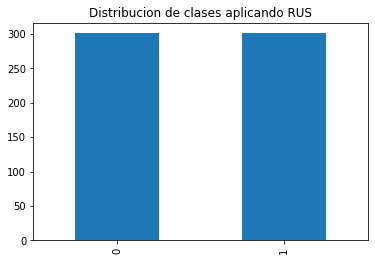

In [67]:
pd.Series(y_rus).value_counts().plot(kind='bar', title='Distribucion de clases aplicando RUS')

In [68]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_rus = X_rus.reshape(X_rus.shape[0],X_rus.shape[1],1)
X_rus.shape, y_rus.shape

((602, 28, 1), (602,))

In [69]:
X_rus_float=X_rus.astype(np.float32)

In [70]:
y_rus_int = y_rus.astype(np.int32)

In [71]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)

model_rus = modelLSTM(200, 'sigmoid', 0.2, 'adam')

model_rus.fit(X_rus_float, y_rus_int, validation_data=(X_test, y_test),epochs=20,callbacks=[cp, earlyStop])


Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 0.7193 - accuracy: 0.4734

19/19 [==============================] - 7s 306ms/step - loss: 0.7193 - accuracy: 0.4734 - val_loss: 0.6930 - val_accuracy: 0.5033
Epoch 2/20
19/19 [==============================] - 1s 47ms/step - loss: 0.7136 - accuracy: 0.4834 - val_loss: 0.6964 - val_accuracy: 0.4902
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.5017

19/19 [==============================] - 5s 291ms/step - loss: 0.7053 - accuracy: 0.5017 - val_loss: 0.6916 - val_accuracy: 0.5163
Epoch 4/20
18/19 [===========================>..] - ETA: 0s - loss: 0.6992 - accuracy: 0.5295

19/19 [==============================] - 5s 272ms/step - loss: 0.6967 - accuracy: 0.5382 - val_loss: 0.6670 - val_accuracy: 0.5817
Epoch 5/20
19/19 [==============================] - 1s 45ms/step - loss: 0.6941 - accuracy: 0.5631 - val_loss: 0.6760 - val_accuracy: 0.5686
Epoch 6/20
19/19 [==============================] - 1s 49ms/step - loss: 0.6867 - accuracy: 0.5449 - val_loss: 0.6853 - val_accuracy: 0.5294
Epoch 7/20
19/19 [==============================] - 1s 45ms/step - loss: 0.6818 - accuracy: 0.5764 - val_loss: 0.6694 - val_accuracy: 0.5948
Epoch 8/20
19/19 [==============================] - 1s 45ms/step - loss: 0.6763 - accuracy: 0.5930 - val_loss: 0.6923 - val_accuracy: 0.5490
Epoch 9/20
19/19 [==============================] - 1s 45ms/step - loss: 0.6875 - accuracy: 0.5731 - val_loss: 0.6925 - val_accuracy: 0.5425
Epoch 10/20
19/19 [==============================] - 1s 46ms/step - loss: 0.6726 - accuracy: 0.5897 - val_loss: 0.6786 - val_accuracy: 0.5752
Epoch 11/20
19/19 [===

In [72]:
scores = model_rus.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_rus.metrics_names[1], scores[1] * 100))


5/5 - 0s - loss: 0.6700 - accuracy: 0.6013 - 72ms/epoch - 14ms/step
accuracy: 60.13%


In [73]:
# print classification report
y_pred_model_rus = model_rus.predict(X_test)

y_pred_model_rus_1 = np.argmax(y_pred_model_rus, axis=1)
print(classification_report(y_test, y_pred_model_rus_1))

5/5 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        81
           1       0.00      0.00      0.00        72

    accuracy                           0.53       153
   macro avg       0.26      0.50      0.35       153
weighted avg       0.28      0.53      0.37       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[81  0]
 [72  0]]


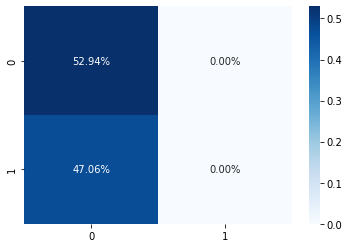

In [74]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_rus_1)
print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

## 1.5.1 GridSearch - Modelo LSTM con division manual (X_rus_float, y_rus_int)




In [75]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_rus_float, y_rus_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.593085 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.556639 (0.070424) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.505000 (0.010336) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.002613) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.571474 (0.041833) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.501667 (0.004236) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.501653 (0.002024) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [76]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f55d649f280>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

In [77]:
# print classification report
y_pred = final_model.predict(X_test.astype(np.float32))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.40      0.50        81
           1       0.54      0.81      0.65        72

    accuracy                           0.59       153
   macro avg       0.62      0.60      0.58       153
weighted avg       0.62      0.59      0.57       153



In [ ]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

Conjunto de datos de validación
  Exactitud:     0.56209
  Precisión:     0.56195
  Exhaustividad: 0.55799
              precision    recall  f1-score   support

           0       0.56      0.43      0.49        74
           1       0.56      0.68      0.62        79

    accuracy                           0.56       153
   macro avg       0.56      0.56      0.55       153
weighted avg       0.56      0.56      0.55       153



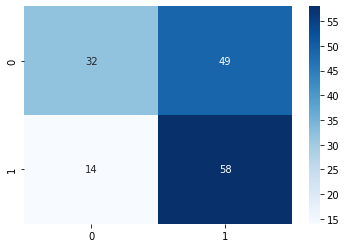

In [78]:
y_pred = final_model.predict(X_test.astype('float32'))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

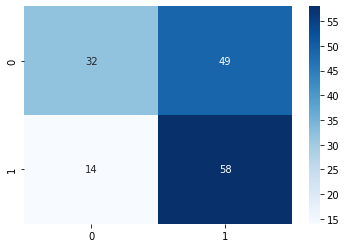

In [79]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

## 1.6. Model LSTM con pesos definidos por class_weight

In [196]:
#Definimos los pesos para el balanceo de clases.
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.995114006514658, 1: 1.0049342105263157}


In [197]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=8)

model_1 = modelLSTM(150, 'sigmoid', 0.3, 'adam')

model_1.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20,class_weight=class_weights, callbacks=[cp, earlyStop])

Epoch 1/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7184 - accuracy: 0.5164

20/20 [==============================] - 7s 268ms/step - loss: 0.7193 - accuracy: 0.5155 - val_loss: 0.6950 - val_accuracy: 0.4248
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7081 - accuracy: 0.5049

20/20 [==============================] - 6s 300ms/step - loss: 0.7084 - accuracy: 0.5025 - val_loss: 0.6931 - val_accuracy: 0.5098
Epoch 3/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7178 - accuracy: 0.5148

20/20 [==============================] - 5s 256ms/step - loss: 0.7174 - accuracy: 0.5155 - val_loss: 0.6931 - val_accuracy: 0.5098
Epoch 4/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7263 - accuracy: 0.4852

20/20 [==============================] - 5s 250ms/step - loss: 0.7260 - accuracy: 0.4861 - val_loss: 0.6929 - val_accuracy: 0.5163
Epoch 5/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7210 - accuracy: 0.4638

20/20 [==============================] - 5s 270ms/step - loss: 0.7211 - accuracy: 0.4632 - val_loss: 0.6897 - val_accuracy: 0.5359
Epoch 6/20
19/20 [===========================>..] - ETA: 0s - loss: 0.6922 - accuracy: 0.5641

20/20 [==============================] - 6s 311ms/step - loss: 0.6917 - accuracy: 0.5663 - val_loss: 0.6658 - val_accuracy: 0.6340
Epoch 7/20
20/20 [==============================] - 1s 33ms/step - loss: 0.6940 - accuracy: 0.5777 - val_loss: 0.6765 - val_accuracy: 0.5556
Epoch 8/20
19/20 [===========================>..] - ETA: 0s - loss: 0.6804 - accuracy: 0.5773

20/20 [==============================] - 5s 251ms/step - loss: 0.6797 - accuracy: 0.5777 - val_loss: 0.6638 - val_accuracy: 0.6209
Epoch 9/20
20/20 [==============================] - 1s 35ms/step - loss: 0.7030 - accuracy: 0.5434 - val_loss: 0.6797 - val_accuracy: 0.5948
Epoch 10/20
20/20 [==============================] - 1s 35ms/step - loss: 0.6865 - accuracy: 0.5532 - val_loss: 0.6715 - val_accuracy: 0.6013
Epoch 11/20
20/20 [==============================] - 1s 34ms/step - loss: 0.6772 - accuracy: 0.5990 - val_loss: 0.6701 - val_accuracy: 0.6013
Epoch 12/20
20/20 [==============================] - 1s 37ms/step - loss: 0.6884 - accuracy: 0.5876 - val_loss: 0.6710 - val_accuracy: 0.5948
Epoch 13/20
20/20 [==============================] - 1s 51ms/step - loss: 0.6836 - accuracy: 0.5794 - val_loss: 0.6737 - val_accuracy: 0.5882
Epoch 14/20
20/20 [==============================] - 1s 60ms/step - loss: 0.6821 - accuracy: 0.5876 - val_loss: 0.6839 - val_accuracy: 0.5556
Epoch 15/20
20/20 

In [198]:
scores = model_1.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

5/5 [==============================] - 0s 23ms/step - loss: 0.6934 - accuracy: 0.5359
Accuracy: 53.59%


In [ ]:
# print classification report
y_pred = model_1.predict(X_test.astype(np.float32))

print(classification_report(y_test, y_pred))

In [ ]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test, y_pred, average = "macro") :0.5f}')

print(classification_report(y_test, y_pred))

Conjunto de datos de validación
  Exactitud:     0.56209
  Precisión:     0.56195
  Exhaustividad: 0.55799
              precision    recall  f1-score   support

           0       0.56      0.43      0.49        74
           1       0.56      0.68      0.62        79

    accuracy                           0.56       153
   macro avg       0.56      0.56      0.55       153
weighted avg       0.56      0.56      0.55       153



In [200]:
y_pred_model_2 = model_1.predict(X_test)

5/5 [==============================] - 1s 12ms/step


In [201]:
# print classification report
y_pred_model2 = np.argmax(y_pred_model_2, axis=1)
print(classification_report(y_test, y_pred_model2))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66        75
           1       0.00      0.00      0.00        78

    accuracy                           0.49       153
   macro avg       0.25      0.50      0.33       153
weighted avg       0.24      0.49      0.32       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[75  0]
 [78  0]]


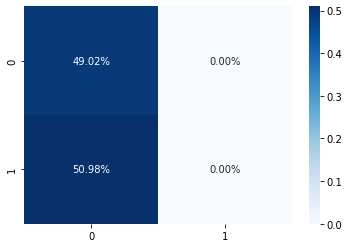

In [202]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model2)
print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 2. Division de datos (Aleatoria)

---



In [8]:
from sklearn.model_selection import train_test_split

df_sin_movilidad_20_21 = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_sin_movilidad_20_21.csv", sep = ";")
df_sin_movilidad_20_21.index = df_sin_movilidad_20_21.fecha  ##Set_index('fecha')
df_sin_movilidad_20_21 = df_sin_movilidad_20_21.drop('fecha', axis=1)

In [9]:
df_sin_movilidad_20_21 = df_sin_movilidad_20_21.loc['2020-02-21':'2021-05-09'] 
print(df_sin_movilidad_20_21.shape)

(84515, 23)


In [10]:
df_sin_movilidad_20_21.groupby("ocurrencia").count()

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,municipio,cod_municipio,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,,,
0,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133,...,84133,84133,84133,84133,84133,84133,84133,84133,84133,84133
1,382,382,382,382,382,382,382,382,382,382,...,382,382,382,382,382,382,382,382,382,382


In [11]:
df_sin_movilidad_20_21.groupby("ocurrencia").count().columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'municipio', 'cod_municipio', 'laborable', 'dayofyear', 'weekend',
       'mes'],
      dtype='object')

In [12]:
df_ocurrencia_0 = df_sin_movilidad_20_21[df_sin_movilidad_20_21["ocurrencia"]==0].sample(382)

In [13]:
df_ocurrencia_1 = df_sin_movilidad_20_21[df_sin_movilidad_20_21["ocurrencia"]==1]

In [14]:
df_sin_movilidad_20_21 =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_sin_movilidad_20_21.shape

(764, 23)

In [15]:
x = df_sin_movilidad_20_21['indicativo'].unique()
len(x)

182

In [16]:
X = df_sin_movilidad_20_21.drop( ['ocurrencia', 'municipio', 'cod_municipio', 'indicativo'], axis=1)
y = df_sin_movilidad_20_21['ocurrencia']

In [17]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2,  shuffle=True)


In [18]:
df_sin_movilidad_20_21.shape, X_train_1.shape, y_train_1.shape, X_test_1.shape, y_test_1.shape

((764, 23), (611, 19), (611,), (153, 19), (153,))

# 2.1 Normalizacion datos



In [19]:
# normalizacion de los datos numericos
from sklearn.preprocessing import StandardScaler
numericalCols_train_1 = X_train_1[["prec","tmed","tmax", "tmin", "velmedia", "racha", "sol", "presMax","presMin","rhum", "altitud", "porcentaje_pendiente_total"]] 
numericalCols_test_1 = X_test_1[["prec","tmed","tmax", "tmin","velmedia", "racha", "sol", "presMax","presMin","rhum", "altitud", "porcentaje_pendiente_total"]] 

scaler = StandardScaler()
scaler.fit(numericalCols_train_1)

numericalCols_train_scaled_1 = scaler.transform(numericalCols_train_1)
numericalCols_test_scaled_1 = scaler.transform(numericalCols_test_1)

numericalCols_train_scaled_1.shape , numericalCols_test_scaled_1.shape

((611, 12), (153, 12))

In [20]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train_1 = X_train_1[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train_1 = OneHotEncoder().fit_transform(categoricalCols_train_1).toarray()

# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test_1 = X_test_1[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	 y vulner
categoricalCols_test_1 = OneHotEncoder().fit_transform(categoricalCols_test_1).toarray()

categoricalCols_train_1.shape, categoricalCols_test_1.shape

((611, 12), (153, 12))

In [21]:
Other_var_train_1 = X_train_1[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test_1 = X_test_1[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [22]:
df_train_scaled_1 = np.concatenate((numericalCols_train_scaled_1 , categoricalCols_train_1, Other_var_train_1), axis=1)
df_test_scaled_1 = np.concatenate((numericalCols_test_scaled_1 , categoricalCols_test_1, Other_var_test_1), axis=1)

In [23]:
df_train_scaled_1.shape, y_train_1.shape, df_test_scaled_1.shape, y_test_1.shape

((611, 28), (611,), (153, 28), (153,))

In [24]:
X_train_1 = df_train_scaled_1.reshape(df_train_scaled_1.shape[0],df_train_scaled_1.shape[1],1)
X_train_1.shape, y_train_1.shape

((611, 28, 1), (611,))

In [25]:
X_test_1 = df_test_scaled_1.reshape(df_test_scaled_1.shape[0],df_test_scaled_1.shape[1],1)
X_test_1.shape, y_test_1.shape

((153, 28, 1), (153,))

# 2.2 Model LSTM (df_sin_mov_20_21 - Division Aleatoria)

In [78]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer


def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((28,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(28, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [79]:
model_shuffle = modelLSTM()

In [80]:
model_shuffle.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 200)               161600    
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 28)                5628      
                                                                 
 dropout_11 (Dropout)        (None, 28)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 29        
                                                                 
Total params: 167,257
Trainable params: 167,257
Non-trainable params: 0
_________________________________________________________________


In [81]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model_shuffle.fit(X_train_1, y_train_1,validation_data=(X_test_1, y_test_1),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.5401

20/20 [==============================] - 7s 238ms/step - loss: 0.6953 - accuracy: 0.5401 - val_loss: 0.6836 - val_accuracy: 0.5948
Epoch 2/20
20/20 [==============================] - 0s 7ms/step - loss: 0.7164 - accuracy: 0.4992 - val_loss: 0.7011 - val_accuracy: 0.4248
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.6989 - accuracy: 0.4959 - val_loss: 0.7020 - val_accuracy: 0.3856
Epoch 4/20
20/20 [==============================] - 0s 10ms/step - loss: 0.6860 - accuracy: 0.5761 - val_loss: 0.7133 - val_accuracy: 0.5686
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 0.7009 - accuracy: 0.5401 - val_loss: 0.7077 - val_accuracy: 0.5033
Epoch 6/20
18/20 [==========================>...] - ETA: 0s - loss: 0.6809 - accuracy: 0.5851

20/20 [==============================] - 5s 255ms/step - loss: 0.6786 - accuracy: 0.5876 - val_loss: 0.6709 - val_accuracy: 0.5686
Epoch 7/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6891 - accuracy: 0.5417 - val_loss: 0.7293 - val_accuracy: 0.3791
Epoch 8/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6799 - accuracy: 0.5712 - val_loss: 0.6849 - val_accuracy: 0.5556
Epoch 9/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6753 - accuracy: 0.5663 - val_loss: 0.6764 - val_accuracy: 0.5621
Epoch 10/20
12/20 [=================>............] - ETA: 0s - loss: 0.6668 - accuracy: 0.5755

20/20 [==============================] - 5s 284ms/step - loss: 0.6704 - accuracy: 0.5777 - val_loss: 0.6597 - val_accuracy: 0.5752
Epoch 11/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6838 - accuracy: 0.5876 - val_loss: 0.6782 - val_accuracy: 0.5882
Epoch 12/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6696 - accuracy: 0.6154 - val_loss: 0.7326 - val_accuracy: 0.5098
Epoch 13/20
20/20 [==============================] - 0s 7ms/step - loss: 0.6762 - accuracy: 0.5941 - val_loss: 0.6666 - val_accuracy: 0.5882
Epoch 14/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6732 - accuracy: 0.5941 - val_loss: 0.6969 - val_accuracy: 0.5490
Epoch 15/20
20/20 [==============================] - 0s 6ms/step - loss: 0.6673 - accuracy: 0.6121 - val_loss: 0.6868 - val_accuracy: 0.5621
Epoch 16/20
20/20 [==============================] - 0s 8ms/step - loss: 0.6605 - accuracy: 0.6007 - val_loss: 0.6885 - val_accuracy: 0.5752
Epoch 17/20
20/20 [====

In [82]:
scores = model_shuffle.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_shuffle.metrics_names[1], scores[1] * 100))

5/5 - 0s - loss: 0.6674 - accuracy: 0.5686 - 28ms/epoch - 6ms/step
accuracy: 56.86%


In [83]:
y_pred_model_1 = model_shuffle.predict(X_test_1.astype('float32'))

5/5 [==============================] - 0s 3ms/step


In [84]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test_1, y_pred_model1))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        95
           1       0.00      0.00      0.00        58

    accuracy                           0.62       153
   macro avg       0.31      0.50      0.38       153
weighted avg       0.39      0.62      0.48       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[95  0]
 [58  0]]


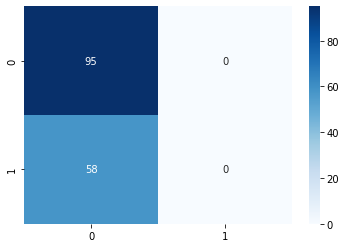

In [85]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

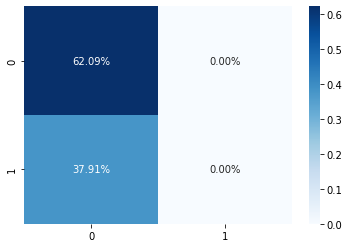

In [86]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 2.2.1 GridSearch -  Hiperparametros del modelo LSTM con division aleatoria  (X_train_1, y_train_1)

In [87]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_train_1, y_train_1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.585899 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.564667 (0.023572) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.530281 (0.003303) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.545035 (0.020447) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.530281 (0.003303) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.585899 (0.039242) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.530281 (0.003303) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}


In [88]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f7c644f7dc0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

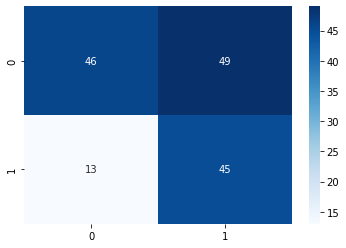

In [89]:
y_pred = final_model.predict(X_test_1.astype('float32'))

cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

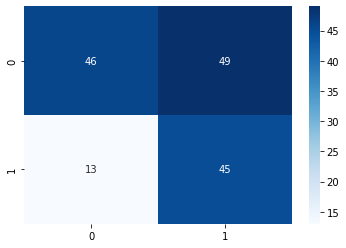

In [90]:
y_pred = (final_model.predict_proba(X_test_1.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

# 2.3. Model LSTM division aleatoria con SMOTE

In [35]:
from imblearn.over_sampling import SMOTE 
X_smote_1 , y_smote_1 = SMOTE().fit_resample( df_train_scaled_1, y_train_1)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train_1 == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_1 == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote_1.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote_1.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote_1 == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote_1 == 0)))

Before OverSampling, counts of label '1': 324
Before OverSampling, counts of label '0': 287 

After OverSampling, the shape of train_X: (648, 28)
After OverSampling, the shape of train_y: (648,) 

After OverSampling, counts of label '1': 324
After OverSampling, counts of label '0': 324


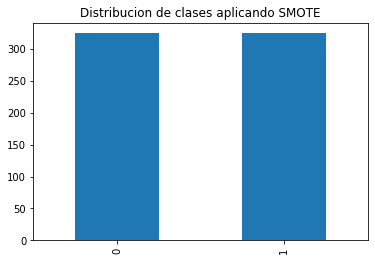

In [36]:
pd.Series(y_smote_1).value_counts().plot(kind='bar', title='Distribucion de clases aplicando SMOTE')

Este gráfico muestra claramente que ahora tenemos una gran cantidad de incendios que antes no teníamos. Esos son todos los puntos de datos sintéticos que se ha creado con SMOTE.



In [37]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_smote_1 = X_smote_1.reshape(X_smote_1.shape[0],X_smote_1.shape[1],1)
X_smote_1.shape, y_smote_1.shape

((648, 28, 1), (648,))

In [38]:
X_smote_float_1 =X_smote_1.astype(np.float32)

In [39]:
y_smote_int_1 = y_smote_1.astype(np.int32)

In [40]:
X_test_1.shape, y_test_1.shape, X_smote_float_1.shape, y_smote_int_1.shape

((153, 28, 1), (153,), (648, 28, 1), (648,))

In [42]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)

model_smote = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_smote.fit(X_smote_float_1, y_smote_int_1,validation_data=(X_test_1, y_test_1),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
20/21 [===========================>..] - ETA: 0s - loss: 0.7164 - accuracy: 0.4953

21/21 [==============================] - 11s 241ms/step - loss: 0.7165 - accuracy: 0.4954 - val_loss: 0.7086 - val_accuracy: 0.3856
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.5494

21/21 [==============================] - 4s 214ms/step - loss: 0.6888 - accuracy: 0.5494 - val_loss: 0.6789 - val_accuracy: 0.6209
Epoch 3/20
21/21 [==============================] - 0s 7ms/step - loss: 0.7080 - accuracy: 0.4753 - val_loss: 0.6896 - val_accuracy: 0.4967
Epoch 4/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6841 - accuracy: 0.5370 - val_loss: 0.6829 - val_accuracy: 0.5686
Epoch 5/20
11/21 [==============>...............] - ETA: 0s - loss: 0.6869 - accuracy: 0.5540

21/21 [==============================] - 5s 263ms/step - loss: 0.6802 - accuracy: 0.5679 - val_loss: 0.6477 - val_accuracy: 0.5752
Epoch 6/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6822 - accuracy: 0.5880 - val_loss: 0.6690 - val_accuracy: 0.5686
Epoch 7/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6737 - accuracy: 0.5725 - val_loss: 0.6580 - val_accuracy: 0.5882
Epoch 8/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6778 - accuracy: 0.5725 - val_loss: 0.6674 - val_accuracy: 0.5425
Epoch 9/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6834 - accuracy: 0.5448 - val_loss: 0.6517 - val_accuracy: 0.5752
Epoch 10/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6748 - accuracy: 0.5833 - val_loss: 0.6810 - val_accuracy: 0.5621
Epoch 11/20
21/21 [==============================] - 0s 6ms/step - loss: 0.6746 - accuracy: 0.6034 - val_loss: 0.6644 - val_accuracy: 0.5752
Epoch 12/20
21/21 [========

In [43]:
scores = model_smote.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_smote.metrics_names[1], scores[1] * 100))


5/5 - 0s - loss: 0.6746 - accuracy: 0.5229 - 28ms/epoch - 6ms/step
accuracy: 52.29%


In [44]:
# print classification report
y_pred_model_bal = model_smote.predict(X_test_1)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test_1, y_pred_model_bal_1))

5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        95
           1       0.00      0.00      0.00        58

    accuracy                           0.62       153
   macro avg       0.31      0.50      0.38       153
weighted avg       0.39      0.62      0.48       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[95  0]
 [58  0]]


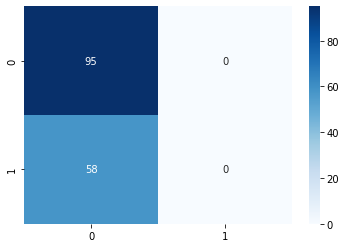

In [45]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# 2.3.1 GridSearch - Modelo LSTM con division aleatoria Smote (X_smote_float, y_smote_int)

In [46]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_smote_float_1, y_smote_int_1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.595766 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.578855 (0.045093) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.002451) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.002451) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.552439 (0.031379) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.002451) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.002451) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [47]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f7c6c4359d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

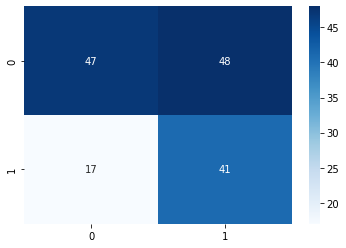

In [48]:
y_pred = final_model.predict(X_test_1.astype('float32'))

cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

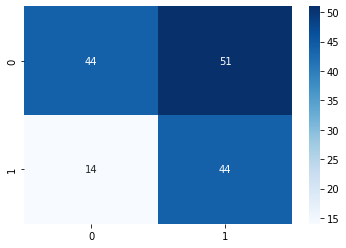

In [57]:
y_pred = (final_model.predict_proba(X_test_1.astype('float32'))[:,1] >= 0.45).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

# 2.4 Model LSTM - Division Aleatoria - Balanceo de clases RandomUnderSampler (y_train_1)


In [58]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(df_train_scaled_1, y_train_1)

print("Before UnderSampling, counts of label '1': {}".format(sum(y_train_1 == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train_1 == 0)))

print('After UnderSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After UnderSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before UnderSampling, counts of label '1': 324
Before UnderSampling, counts of label '0': 287 

After UnderSampling, the shape of train_X: (574, 28)
After UnderSampling, the shape of train_y: (574,) 

After UnderSampling, counts of label '1': 287
After UnderSampling, counts of label '0': 287


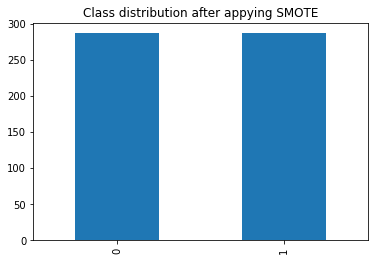

In [59]:
pd.Series(y_rus).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE')

In [60]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_rus = X_rus.reshape(X_rus.shape[0],X_rus.shape[1],1)
X_rus.shape, y_rus.shape

((574, 28, 1), (574,))

In [61]:
X_rus_float = X_rus.astype(np.float32)

In [62]:
y_rus_int = y_rus.astype(np.int32)

In [63]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=20)

model_shuffle_rus = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_shuffle_rus.fit(X_rus_float, y_rus_int,validation_data=(X_test_1, y_test_1),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
11/18 [=================>............] - ETA: 0s - loss: 0.7125 - accuracy: 0.4886 

18/18 [==============================] - 7s 292ms/step - loss: 0.7122 - accuracy: 0.4895 - val_loss: 0.6812 - val_accuracy: 0.5948
Epoch 2/20
18/18 [==============================] - 0s 7ms/step - loss: 0.7070 - accuracy: 0.4913 - val_loss: 0.7182 - val_accuracy: 0.3791
Epoch 3/20
18/18 [==============================] - 0s 7ms/step - loss: 0.7206 - accuracy: 0.4547 - val_loss: 0.6950 - val_accuracy: 0.4771
Epoch 4/20
18/18 [==============================] - 0s 6ms/step - loss: 0.7036 - accuracy: 0.4948 - val_loss: 0.7001 - val_accuracy: 0.4052
Epoch 5/20
12/18 [===================>..........] - ETA: 0s - loss: 0.6874 - accuracy: 0.5495

18/18 [==============================] - 4s 237ms/step - loss: 0.6887 - accuracy: 0.5366 - val_loss: 0.6768 - val_accuracy: 0.5752
Epoch 6/20
11/18 [=================>............] - ETA: 0s - loss: 0.6973 - accuracy: 0.5199

18/18 [==============================] - 5s 264ms/step - loss: 0.6963 - accuracy: 0.5157 - val_loss: 0.6678 - val_accuracy: 0.5752
Epoch 7/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6768 - accuracy: 0.5906 - val_loss: 0.6694 - val_accuracy: 0.5621
Epoch 8/20
11/18 [=================>............] - ETA: 0s - loss: 0.6768 - accuracy: 0.5938

18/18 [==============================] - 4s 236ms/step - loss: 0.6774 - accuracy: 0.5836 - val_loss: 0.6501 - val_accuracy: 0.5752
Epoch 9/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6808 - accuracy: 0.5784 - val_loss: 0.6693 - val_accuracy: 0.5817
Epoch 10/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6752 - accuracy: 0.5976 - val_loss: 0.6618 - val_accuracy: 0.5621
Epoch 11/20
18/18 [==============================] - 0s 6ms/step - loss: 0.6808 - accuracy: 0.5610 - val_loss: 0.6609 - val_accuracy: 0.5882
Epoch 12/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6740 - accuracy: 0.5906 - val_loss: 0.6543 - val_accuracy: 0.5621
Epoch 13/20
18/18 [==============================] - 0s 7ms/step - loss: 0.6830 - accuracy: 0.5087 - val_loss: 0.6645 - val_accuracy: 0.5686
Epoch 14/20
18/18 [==============================] - 0s 6ms/step - loss: 0.6726 - accuracy: 0.5889 - val_loss: 0.6666 - val_accuracy: 0.5752
Epoch 15/20
18/18 [=====

In [64]:
scores = model_shuffle_rus.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_shuffle_rus.metrics_names[1], scores[1] * 100))


5/5 - 0s - loss: 0.6739 - accuracy: 0.5425 - 28ms/epoch - 6ms/step
accuracy: 54.25%


In [66]:
# print classification report
y_pred_model_bal = model_shuffle_rus.predict(X_test_1)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test_1, y_pred_model_bal_1))

5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        95
           1       0.00      0.00      0.00        58

    accuracy                           0.62       153
   macro avg       0.31      0.50      0.38       153
weighted avg       0.39      0.62      0.48       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[95  0]
 [58  0]]


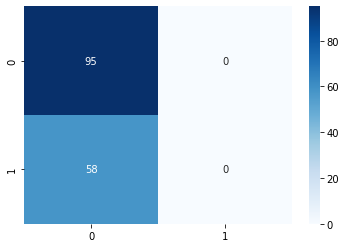

In [67]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# 2.4.1 GridSearch - Modelo LSTM con division aleatoria (X_rus, y_rus)

In [68]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_rus_float, y_rus_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.595850 using {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.541815 (0.052002) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.501739 (0.003478) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003889) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.595850 (0.026222) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003889) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.003889) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [69]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f7c6c4359d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

In [71]:
y_pred = final_model.predict(X_test_1.astype(np.float32))

In [72]:
# print classification report
y_pred = final_model.predict(X_test_1.astype(np.float32))

print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.40      0.52        95
           1       0.44      0.76      0.55        58

    accuracy                           0.54       153
   macro avg       0.58      0.58      0.54       153
weighted avg       0.62      0.54      0.53       153



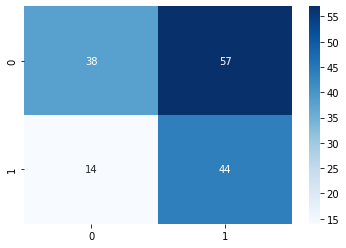

In [73]:
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

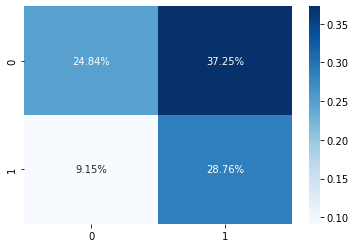

In [74]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

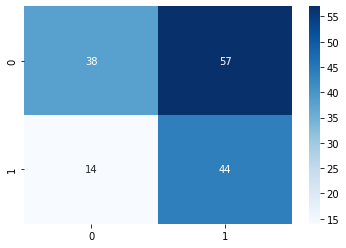

In [75]:
y_pred = (final_model.predict_proba(X_test_1.astype(np.float32))[:,1] >= 0.4).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [76]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test_1, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test_1, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test_1, y_pred, average = "macro") :0.5f}')


Conjunto de datos de validación
  Exactitud:     0.53595
  Precisión:     0.58321
  Exhaustividad: 0.57931


In [77]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.40      0.52        95
           1       0.44      0.76      0.55        58

    accuracy                           0.54       153
   macro avg       0.58      0.58      0.54       153
weighted avg       0.62      0.54      0.53       153



#Variables importantes (Modelo Simple)

---



#Seleccion de variables importantes (Modelo Simple)


In [70]:
df_sin_movilidad_20_21.columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'ocurrencia', 'municipio', 'cod_municipio', 'laborable', 'dayofyear',
       'weekend', 'mes'],
      dtype='object')

In [71]:
df_sin_mov_20_21_importances = df_sin_movilidad_20_21.drop([ 'indicativo', 'tmed', 'tmin', 'presMin', 'municipio', 'cod_municipio', 'porcentaje_pendiente_total','altitud', 'vulner', 'alto_riesgo', 'laborable', 'weekend'], axis=1)
df_sin_mov_20_21_importances

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,ocurrencia,dayofyear,mes
fecha,,,,,,,,,,,
2020-12-22,0.0,15.9,1.7,2.9,431.0,988.8,63.0,Molt Alt,0,357,12
2020-09-15,0.0,30.4,2.0,4.3,777.0,1007.2,41.0,Exclos,0,259,9
2021-05-09,0.0,20.0,1.1,2.9,174.0,1008.1,60.0,Alt,0,129,5
2020-07-05,0.0,31.4,5.6,10.9,962.0,995.9,39.0,Molt Alt,0,187,7
2020-05-16,0.0,21.1,4.9,10.8,494.0,984.8,57.0,Molt Alt,0,137,5
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-08,0.0,25.5,2.5,7.1,953.0,1013.2,51.0,Molt Alt,1,128,5
2021-05-08,0.0,25.5,4.9,8.6,960.0,1003.5,47.0,Exclos,1,128,5
2021-05-08,0.0,27.8,2.4,4.8,923.0,1016.3,43.0,Molt Alt,1,128,5


In [72]:
df_sin_mov_20_21_importances.groupby("ocurrencia").count()

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,dayofyear,mes
ocurrencia,,,,,,,,,,
0,382,382,382,382,382,382,382,382,382,382
1,382,382,382,382,382,382,382,382,382,382


In [73]:
df_sin_mov_20_21_importances.groupby("ocurrencia").count().columns

Index(['prec', 'tmax', 'velmedia', 'racha', 'sol', 'presMax', 'rhum',
       'peligro', 'dayofyear', 'mes'],
      dtype='object')

In [74]:
df_ocurrencia_0 = df_sin_mov_20_21_importances[df_sin_mov_20_21_importances["ocurrencia"]==0].sample(382)

In [75]:
df_ocurrencia_1 = df_sin_mov_20_21_importances[df_sin_mov_20_21_importances["ocurrencia"]==1]

In [76]:
df_sin_mov_20_21_importances =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_sin_mov_20_21_importances.shape
df_sin_mov_20_21_importances

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,ocurrencia,dayofyear,mes
fecha,,,,,,,,,,,
2020-08-03,0.0,29.4,7.3,12.3,953.0,1010.4,34.0,Exclos,0,216,8
2021-04-09,1.2,11.0,1.7,3.3,74.0,1022.0,89.0,Exclos,0,99,4
2020-10-09,0.0,24.9,2.4,5.1,641.0,981.9,60.0,Molt Alt,0,283,10
2020-09-27,0.0,16.8,3.0,6.3,544.0,1010.5,41.0,Molt Alt,0,271,9
2020-07-04,0.0,24.4,1.8,4.3,1012.0,1012.3,41.0,Molt Alt,0,186,7
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-08,0.0,25.5,2.5,7.1,953.0,1013.2,51.0,Molt Alt,1,128,5
2021-05-08,0.0,25.5,4.9,8.6,960.0,1003.5,47.0,Exclos,1,128,5
2021-05-08,0.0,27.8,2.4,4.8,923.0,1016.3,43.0,Molt Alt,1,128,5


In [77]:
X = df_sin_mov_20_21_importances.drop( ['ocurrencia'], axis=1)
y = df_sin_mov_20_21_importances['ocurrencia']

In [78]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2)

In [79]:
df_sin_movilidad_20_21.shape,  X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape

((764, 23), (611, 10), (611,), (153, 10), (153,))

In [80]:
# normalizacion de los datos numericos
numericalCols_train = X_train_2[['prec'	,'tmax',	'velmedia',	'racha',	'sol'	,'presMax',	'rhum']]
numericalCols_test = X_test_2[['prec'	,'tmax',	'velmedia',	'racha',	'sol'	,'presMax',	'rhum']]

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((611, 7), (153, 7))

In [81]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train_2[[	'peligro']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test_2[['peligro']]   #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((611, 5), (153, 5))

In [82]:
Other_var_train = X_train_2[[	'mes', 'dayofyear']]
Other_var_test = X_test_2[[	'mes', 'dayofyear']]  #alto_riesgo	peligro	 y vulner

In [83]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)

In [84]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((611, 14), (611,), (153, 14), (153,))

In [85]:
X_test_2 = df_test_scaled
X_train_2 = df_train_scaled

##Model LSTM (Variables importantes)

In [86]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer


def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 64):
    model=Sequential()
    model.add(InputLayer((14,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(14, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [87]:
model_import = modelLSTM()

In [88]:
model_import.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200)               161600    
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 14)                2814      
                                                                 
 dropout_7 (Dropout)         (None, 14)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 15        
                                                                 
Total params: 164,429
Trainable params: 164,429
Non-trainable params: 0
_________________________________________________________________


In [89]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model_import.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
19/20 [===========================>..] - ETA: 0s - loss: 0.7016 - accuracy: 0.5296

20/20 [==============================] - 7s 262ms/step - loss: 0.7023 - accuracy: 0.5270 - val_loss: 0.6925 - val_accuracy: 0.5229
Epoch 2/20
18/20 [==========================>...] - ETA: 0s - loss: 0.6978 - accuracy: 0.5174

20/20 [==============================] - 5s 267ms/step - loss: 0.6983 - accuracy: 0.5237 - val_loss: 0.6671 - val_accuracy: 0.6013
Epoch 3/20
20/20 [==============================] - 1s 27ms/step - loss: 0.6810 - accuracy: 0.5614 - val_loss: 0.6734 - val_accuracy: 0.5621
Epoch 4/20
20/20 [==============================] - 1s 27ms/step - loss: 0.6668 - accuracy: 0.6007 - val_loss: 0.6696 - val_accuracy: 0.5686
Epoch 5/20
19/20 [===========================>..] - ETA: 0s - loss: 0.6697 - accuracy: 0.5757

20/20 [==============================] - 5s 239ms/step - loss: 0.6691 - accuracy: 0.5761 - val_loss: 0.6580 - val_accuracy: 0.6209
Epoch 6/20
18/20 [==========================>...] - ETA: 0s - loss: 0.6776 - accuracy: 0.5972

20/20 [==============================] - 5s 274ms/step - loss: 0.6773 - accuracy: 0.5974 - val_loss: 0.6501 - val_accuracy: 0.6275
Epoch 7/20
20/20 [==============================] - 1s 26ms/step - loss: 0.6703 - accuracy: 0.5745 - val_loss: 0.6639 - val_accuracy: 0.6013
Epoch 8/20
20/20 [==============================] - 1s 28ms/step - loss: 0.6611 - accuracy: 0.5990 - val_loss: 0.6566 - val_accuracy: 0.6013
Epoch 9/20
20/20 [==============================] - 1s 25ms/step - loss: 0.6722 - accuracy: 0.5908 - val_loss: 0.6575 - val_accuracy: 0.5948
Epoch 10/20
20/20 [==============================] - 1s 27ms/step - loss: 0.6733 - accuracy: 0.5728 - val_loss: 0.6611 - val_accuracy: 0.5882
Epoch 11/20
20/20 [==============================] - 1s 27ms/step - loss: 0.6524 - accuracy: 0.6203 - val_loss: 0.6563 - val_accuracy: 0.6275
Epoch 12/20
20/20 [==============================] - 1s 27ms/step - loss: 0.6605 - accuracy: 0.6203 - val_loss: 0.6577 - val_accuracy: 0.6013
Epoch 13/20
20/20 [=

In [90]:
scores = model_import.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_import.metrics_names[1], scores[1] * 100))

5/5 - 0s - loss: 0.6520 - accuracy: 0.6144 - 51ms/epoch - 10ms/step
accuracy: 61.44%


In [91]:
y_pred_model_1 = model_import.predict(X_test)

5/5 [==============================] - 0s 10ms/step


In [92]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test, y_pred_model1))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66        76
           1       0.00      0.00      0.00        77

    accuracy                           0.50       153
   macro avg       0.25      0.50      0.33       153
weighted avg       0.25      0.50      0.33       153



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[76  0]
 [77  0]]


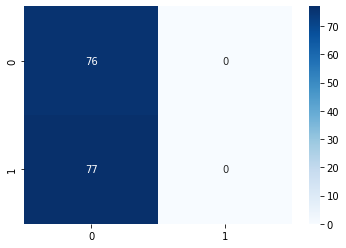

In [93]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

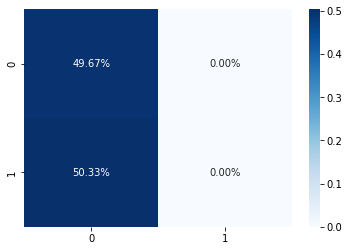

In [94]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')